In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np

from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

# Module to save and load Python objects to and from files
import pickle  


In [2]:
# Import Data
df = pd.read_csv('fetal_health.csv')
df.head()

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [3]:
# Select input and output features
X = df.drop(columns = ['fetal_health'])
y = df['fetal_health']
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [4]:
# Estimators
rf_clf = RandomForestClassifier(random_state = 42)
dt_clf = DecisionTreeClassifier(random_state = 42)
Ada_clf = AdaBoostClassifier(n_estimators=100, random_state=0)

In [5]:
# get f1 scores and assign weights
    # loop suggested by chatgpt
f1_scores = {}
for clf in (rf_clf, dt_clf, Ada_clf):
    clf.fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    f1 = f1_score(test_y, pred_y, average='macro')
    f1_scores[clf.__class__.__name__] = f1
    print(f"{clf.__class__.__name__} F1-macro Score: {f1:.4f}")

weights = np.array(list(f1_scores.values()))
weights = weights / weights.sum()
print("Weights (normalized to 1):", weights)



RandomForestClassifier F1-macro Score: 0.9030
DecisionTreeClassifier F1-macro Score: 0.8877


C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier F1-macro Score: 0.8395
Weights (normalized to 1): [0.34332621 0.33749091 0.31918288]


In [6]:
# Soft Voting Classifier
softVote_clf = VotingClassifier(estimators=[('rf', rf_clf), ('dt', dt_clf), ('adb', Ada_clf)], voting='soft', weights=weights) # n_jobs = -1?
softVote_clf.fit(train_X, train_y)

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('adb',
                              AdaBoostClassifier(n_estimators=100,
                                                 random_state=0))],
                 voting='soft',
                 weights=array([0.34332621, 0.33749091, 0.31918288]))

In [7]:
feature_importance = {}
for clf_name, clf in zip(f1_scores.keys(), [rf_clf, dt_clf, Ada_clf]):
    if hasattr(clf, 'feature_importances_'):
        feature_importance[clf_name] = clf.feature_importances_
    else:
        feature_importance[clf_name] = np.zeros(X.shape[1])

combined_feature_importance = np.zeros(X.shape[1])
for i, clf_name in enumerate(f1_scores.keys()):
    combined_feature_importance += weights[i] * feature_importance[clf_name]    

combined_feature_importanceDisplay = pd.Series(combined_feature_importance, index=X.columns).sort_values(ascending=False)
print(combined_feature_importanceDisplay)



histogram_mean                                            0.158157
mean_value_of_short_term_variability                      0.145090
abnormal_short_term_variability                           0.123824
percentage_of_time_with_abnormal_long_term_variability    0.095807
uterine_contractions                                      0.051363
mean_value_of_long_term_variability                       0.047268
baseline_value                                            0.047084
histogram_mode                                            0.043494
prolongued_decelerations                                  0.038782
accelerations                                             0.037716
histogram_number_of_peaks                                 0.033523
histogram_median                                          0.032300
fetal_movement                                            0.029862
histogram_width                                           0.025789
histogram_variance                                        0.02

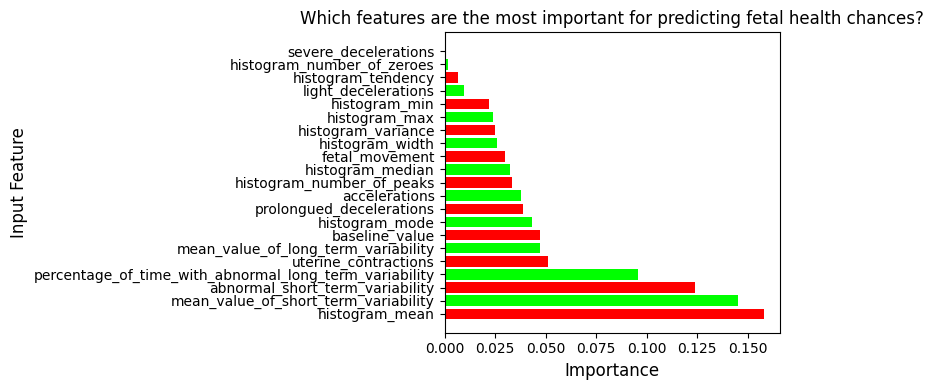

In [8]:
# Storing importance values from the trained model
importance = combined_feature_importance

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting fetal health chances?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();
# save feature importance
plt.savefig("feature_imp_sv.svg", bbox_inches = 'tight')

In [9]:
# for clf in (rf_clf, dt_clf, Ada_clf, softVote_clf):
#     clf.fit(train_X, train_y)
#     pred_y = clf.predict(test_X)
#     f1 = f1_score(test_y, pred_y, average='weighted')
#     print(f"{clf.__class__.__name__} F1 Score: {f1:.4f}")

    

In [10]:
sv_pickle = open('SoftVote_fh.pickle', 'wb') 

# Write DT model to the file
pickle.dump(softVote_clf, sv_pickle) 

# Close the file
sv_pickle.close() 
